<a href="https://colab.research.google.com/github/skynunu/StockPrediction_Project_bigdata/blob/main/lstm_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import sys
from pathlib import Path
from datetime import timedelta
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from contextlib2 import redirect_stdout
import random
from ipywidgets import FloatProgress
import sklearn
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
#%cd /content/drive/MyDrive/bigdata_term_project_2021/
%cd /content/drive/MyDrive/수업/빅데이터/과제/코드/

/content/drive/MyDrive/수업/빅데이터/과제/코드


In [206]:
#기본 하이퍼 파라미터
WINDOW_GIVEN = 19
BATCH_SIZE = 64
WINDOW_SIZE = WINDOW_GIVEN + 1
EPOCH = 60 

#모델 파라미터 설정
N_HIDDENS1 = 100
N_LAYERS1 = 3
DROPOUT1 =0
LEARNING_RATE = 0.01

#이름 설정
Filenum = "LSTM_"
PATH = "LSTM_"+str(WINDOW_GIVEN)+"_"+str(BATCH_SIZE)+"_"+str(EPOCH)

In [207]:
class Dataset(Dataset):
    def __init__(self, df, stride=1):
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(df.shape[0] - WINDOW_SIZE + 1):
          self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")

    def __len__(self):
        return self.n_idxs
    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_GIVEN
        item = {}
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])

        if i == 0  :
          item['class'] = 0
        elif self.tag_values[i][3] <= self.tag_values[i-1][3] : 
          item['class'] = 0
        else :
          item['class'] = 1  
  
        
        return item

In [208]:
def make_lstm_dataset(raw_data, scaler):
    delete_columns = ['Unnamed: 0', "Date", "Close", 'year', 'month']
    raw_data= raw_data.drop(columns =delete_columns )
    raw_data = raw_data.dropna()

    data_normal= scaler.transform(raw_data)
    data_normal_pd = pd.DataFrame(data_normal)
    DATASET_TRAIN = Dataset(data_normal)
    return DATASET_TRAIN


In [209]:
def model_test_score(dataset, model, scaler) : 
  test_predict, test_answer,  test_label = get_result(dataset , BATCH_SIZE, model)
  test_scaled = scaler.inverse_transform(test_predict.reshape(-1, 1))
  predict_label = check_class(test_scaled) #예측한 값들을 전날 기준으로 상승 감소여부를 판단해서 클래스로 산출

  accuracy = np.round(accuracy_score(predict_label, test_label),3)
  f1 = np.round(f1_score(predict_label, test_label),3)
  precision = np.round(precision_score(predict_label, test_label),3)
  recall = np.round(recall_score(predict_label, test_label),3)

  return accuracy, f1, precision, recall

In [210]:
def get_result(dataset, batch_size, model):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    predict_list, answer_list, label_list = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            label = batch["class"].cuda()
            guess = model(given)

            predict_list.append(guess.cpu().numpy())
            answer_list.append(answer.cpu().numpy())
            label_list.append(label.cpu().numpy())

    return (
        np.concatenate(predict_list),
        np.concatenate(answer_list),
        np.concatenate(label_list),
    )

In [211]:
#예측한 값들을 전날 기준으로 상승 감소여부를 판단해서 클래스로 산출하는 함수
def check_class(result) :
  length = result.shape[0] 
  result = result[:,0]
  class_list = [0]
  for i in range(1,length) :
    if result[i]>result[i-1] :
      class_list.append(1)
    else :
      class_list.append(0)
  return class_list

##1. 데이터 불러오기 & 전처리

###(1) 학습 데이터
  * 아마존 애플 넷플릭스 페이스북 구글 2000년이후 데이터 불러오기
  * 아마존 :  2014년, 2015년  /  애플 :  2017년 / 넷플릭스 :  2012년, 2017년 / 페이스북:  2017년 / 구글: 2008년 제외 
  * 제외한 년도 데이터는 테스트 데이터로 사용


  ### (2) 테스트 데이터
  * 아마존 :  2014년, 2015년 /  애플 :  2017년 , 1985년   / 넷플릭스 :  2012년, 2017년 /  구글: 2008년  / 페이스북:  2017년 
  * 데이터의 상승 하강 패턴을 고려해서 테스트 데이터셋 구성
  * 상승년도 4년 : amazon 2015년 / apple 2017년 / netflix 2017년 / facebook 2017년
  * 하강년도 4년 :  amazon 2014년 / apple 1985년 /  netflix 2012년 / google 2008년 

In [212]:
# 학습 데이터 불러오기
amazon = pd.read_csv('data/amazon_new.csv')
apple = pd.read_csv('data/apple_new.csv')
facebook = pd.read_csv('data/facebook_new.csv')
google = pd.read_csv('data/google_new.csv')
netflix = pd.read_csv('data/netflix_new.csv')

# slinding window를 할때, 년도별 잘린 구간을 구분하고자, 잘린 구간을 기점으로 데이터셋 구성
# 년도별 잘린 구간은 테스트 데이터셋으로 구성

# 아마존 2014년, 2015년 제외
amazon = amazon[amazon['year'] >=2000]
amazon_train1 = amazon[amazon['year'] <2014] 
amazon_train2 = amazon[amazon['year'] >2015] 

# 애플 2017년 제외
apple = apple[apple['year'] >=2000]
apple_train1 = apple[apple['year'] <2017] 
apple_train2 = apple[apple['year'] >2017] 

# 넷플릭스 2012년, 2017년 제외
netflix = netflix[netflix['year'] >=2000]
netflix_train1 = netflix[netflix['year'] <=2012] 
netflix_train2 = netflix[(netflix['year']  >=2012) & (netflix['year']  <=2017)] 
netflix_train3 = netflix[netflix['year'] >=2017] 

# 페이스북 2017년 제외
facebook = facebook[facebook['year'] >=2000]
facebook_train1 = facebook[facebook['year'] <=2017] 
facebook_train2 = facebook[facebook['year'] >=2017]

 #구글 2008년 제외
google = google[google['year'] >=2000]
google_train1 = google[google['year'] <=2008] 
google_train2 = google[google['year'] >=2008] 

In [213]:
# 테스트 데이터 불러오기
test_amazon_inc = pd.read_csv('data/amazon_inc.csv')
test_amazon_dec = pd.read_csv('data/amazon_dec.csv')

test_apple_inc = pd.read_csv('data/apple_inc.csv')
test_apple_dec = pd.read_csv('data/apple_dec.csv')

test_netflix_inc = pd.read_csv('data/netflix_inc.csv')
test_netflix_dec = pd.read_csv('data/netflix_dec.csv')

test_google_dec = pd.read_csv('data/google_dec.csv')
test_facebook_inc = pd.read_csv('data/facebook_inc.csv')

In [214]:
#전체 데이터 normalize 학습 
all_dataset = pd.concat([amazon,apple,netflix,facebook,google], axis = 0)
delete_columns = ['Unnamed: 0', "Date", "Close", 'year', 'month']
all_dataset_drop= all_dataset.drop(columns =delete_columns)
print("all_dataset.shape : ", all_dataset_drop.shape)
scaler = MinMaxScaler()
scaler =scaler.fit(all_dataset_drop)


all_dataset.shape :  (20573, 5)


In [215]:
#학습 dataset 만들기

# 아마존
DATASET_amazon1 = make_lstm_dataset(amazon_train1, scaler)
DATASET_amazon2 = make_lstm_dataset(amazon_train2, scaler)
DATASET_amazon = torch.utils.data.ConcatDataset([DATASET_amazon1, DATASET_amazon2])

# 애플
DATASET_apple1 = make_lstm_dataset(apple_train1, scaler)
DATASET_apple2 = make_lstm_dataset(apple_train2, scaler)
DATASET_apple = torch.utils.data.ConcatDataset([DATASET_apple1, DATASET_apple2])

# 넷플릭스
DATASET_netflix1= make_lstm_dataset(netflix_train1, scaler)
DATASET_netflix2 = make_lstm_dataset(netflix_train2, scaler)
DATASET_netflix3 = make_lstm_dataset(netflix_train3, scaler)
DATASET_netflix = torch.utils.data.ConcatDataset([DATASET_netflix1, DATASET_netflix2, DATASET_netflix3])

# 페이스북
DATASET_facebook1 = make_lstm_dataset(facebook_train1, scaler)
DATASET_facebook2 = make_lstm_dataset(facebook_train2, scaler)
DATASET_facebook = torch.utils.data.ConcatDataset([DATASET_facebook1, DATASET_facebook2])

# 구글
DATASET_google1 = make_lstm_dataset(google_train1, scaler)
DATASET_google2 = make_lstm_dataset(google_train2, scaler)
DATASET_google = torch.utils.data.ConcatDataset([DATASET_google1, DATASET_google2])

# torch dataset 만들고 dataloader 만들기
DATASET_TRAIN = torch.utils.data.ConcatDataset([DATASET_amazon, DATASET_apple, DATASET_netflix, DATASET_facebook, DATASET_google])
train_dataloader = DataLoader(DATASET_TRAIN, batch_size=BATCH_SIZE, shuffle=True, drop_last=True ) 

  0%|          | 0/3502 [00:00<?, ?it/s]

# of valid windows: 3502


  0%|          | 0/1144 [00:00<?, ?it/s]

# of valid windows: 1144


  0%|          | 0/4258 [00:00<?, ?it/s]

# of valid windows: 4258


  0%|          | 0/653 [00:00<?, ?it/s]

# of valid windows: 653


  0%|          | 0/3250 [00:00<?, ?it/s]

# of valid windows: 3250


  0%|          | 0/986 [00:00<?, ?it/s]

# of valid windows: 986


  0%|          | 0/892 [00:00<?, ?it/s]

# of valid windows: 892


  0%|          | 0/1144 [00:00<?, ?it/s]

# of valid windows: 1144


  0%|          | 0/643 [00:00<?, ?it/s]

# of valid windows: 643


  0%|          | 0/1991 [00:00<?, ?it/s]

# of valid windows: 1991


  0%|          | 0/2402 [00:00<?, ?it/s]

# of valid windows: 2402


In [216]:
#테스트 dataset 만들기

#증가 테스트 데이터셋
DATASET_inc1 = make_lstm_dataset(test_amazon_inc, scaler)
DATASET_inc2 = make_lstm_dataset(test_apple_inc, scaler)
DATASET_inc3 = make_lstm_dataset(test_netflix_inc, scaler)
DATASET_inc4 = make_lstm_dataset(test_facebook_inc, scaler)
DATASET_TEST_INC = torch.utils.data.ConcatDataset([DATASET_inc1, DATASET_inc2,DATASET_inc3,DATASET_inc4])

#감소 테스트 데이터셋
DATASET_dec1 = make_lstm_dataset(test_amazon_dec, scaler)
DATASET_dec2 = make_lstm_dataset(test_apple_dec, scaler)
DATASET_dec3 = make_lstm_dataset(test_netflix_dec, scaler)
DATASET_dec4 = make_lstm_dataset(test_google_dec, scaler)
DATASET_TEST_DEC = torch.utils.data.ConcatDataset([DATASET_dec1, DATASET_dec2,DATASET_dec3,DATASET_dec4])

  0%|          | 0/233 [00:00<?, ?it/s]

# of valid windows: 233


  0%|          | 0/232 [00:00<?, ?it/s]

# of valid windows: 232


  0%|          | 0/232 [00:00<?, ?it/s]

# of valid windows: 232


  0%|          | 0/232 [00:00<?, ?it/s]

# of valid windows: 232


  0%|          | 0/233 [00:00<?, ?it/s]

# of valid windows: 233


  0%|          | 0/233 [00:00<?, ?it/s]

# of valid windows: 233


  0%|          | 0/231 [00:00<?, ?it/s]

# of valid windows: 231


  0%|          | 0/234 [00:00<?, ?it/s]

# of valid windows: 234


## 2. 주식 예측 LSTM 구현
###  - 논문 참고 : '주일택' 양방향 LSTM 순환신경망 기반 주가예측모델
###  - github 참고: https://github.com/RodolfoLSS/stock-prediction-pytorch/blob/master/stock-prediction-pytorch.ipynb

In [217]:
class LSTM(torch.nn.Module):
    def __init__(self, n_tags):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=N_HIDDENS1,
            num_layers=N_LAYERS1,
            batch_first = True,  
            dropout=DROPOUT1,
            bidirectional = True
        )
        self.fc = torch.nn.Linear(N_HIDDENS1*2, 1)
    
    def forward(self, x):
        h0 = torch.zeros(N_LAYERS1*2, x.size(0), N_HIDDENS1).requires_grad_().cuda()
        c0 = torch.zeros(N_LAYERS1*2, x.size(0), N_HIDDENS1).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0.detach(),c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
        #return out+x[:,0,:] #skip connection 적용

In [218]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # shuffle 기능 살펴보기
    optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE )
  
    #RMSE 적용-> 학습중에 root 적용
    criterion = torch.nn.MSELoss()
    
    loss_fn = torch.nn.L1Loss() # reduction mean?
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []

    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()

            #RMSE
            loss = loss_fn(answer, guess)            
            loss = torch.sqrt(loss)

            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

## 3. 주식 예측을 위한 LSTM 모델 학습

training:   0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


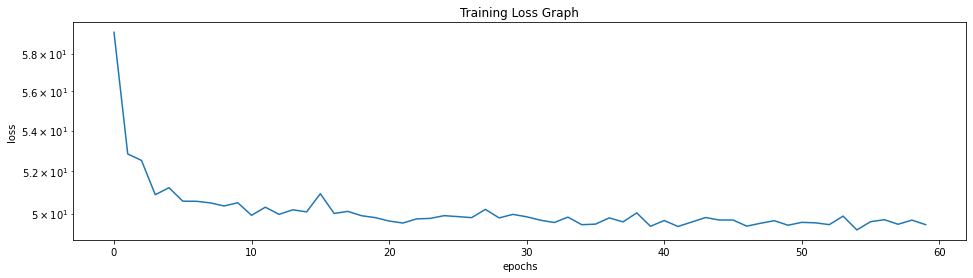

In [219]:
MODEL1 = LSTM(n_tags=5)
MODEL1.cuda()
Filenum1 = Filenum

# Find Best Model
MODEL1.train()
BEST_MODEL1, LOSS_HISTORY1 = train(DATASET_TRAIN, MODEL1, BATCH_SIZE, EPOCH)
BEST_MODEL1["loss"], BEST_MODEL1["epoch"]

with open("model/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + "_" + str(N_HIDDENS1) + "_" + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL1["state"],
            "best_epoch": BEST_MODEL1["epoch"],
            "loss_history": LOSS_HISTORY1,
        },
        f,
    )
with open("model/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + "_" + str(N_HIDDENS1) + "_" + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
    SAVED_MODEL1 = torch.load(f)


torch.cuda.empty_cache()
MODEL1.load_state_dict(SAVED_MODEL1["state"])


plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL1["loss_history"])
plt.savefig("model/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_loss.png")
with open("model/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_loss_history.txt", 'w') as f:
    with redirect_stdout(f):
        print(SAVED_MODEL1["loss_history"])


## 4. 모델 테스트 하기
### - 증가 패턴 데이터셋과 감소 패턴 데이터셋 결과 비교
### - 증가 패턴 데이터셋 : amazon 2015년 / apple 2017년 / netflix 2017년 / facebook 2017년
### - 감소 패턴 데이터셋 :  amazon 2014년 / apple 1985년 /  netflix 2012년 / google 2008년 
### - 실험순서
  
  * 테스트 데이터셋에 대하여, LSTM 예측
  
  * 수정종가 예측값과 수정종가 정답값에 대하여 inverse_normalize 적용
  
  * 수정종가에 대해서 예측한 값 그래프 나타내기 실험

  * 전날 기준으로 증가 감소에 대한 클래스 예측값 산출해서 실제 증감여부와 비교해서 정확도 산출
 

In [220]:
# Model Load
with open("model/" + str(Filenum1) + '_' + str(WINDOW_GIVEN) + '_' + str(N_HIDDENS1) + '_' + str(N_LAYERS1) + '_' + str(BATCH_SIZE) + "_model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

TEST_MODEL = LSTM(n_tags=5)
TEST_MODEL.load_state_dict(SAVED_MODEL["state"])
TEST_MODEL.to(torch.device("cuda")) # use GPU 
TEST_MODEL.eval()

LSTM(
  (lstm): LSTM(5, 100, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [221]:
test_scaler = MinMaxScaler()
all_dataset_adjclose = all_dataset_drop['Adj Close'].to_numpy()
test_scaler.fit(all_dataset_adjclose.reshape(-1, 1))

MinMaxScaler()

### 4-1. 증가 패턴 데이터셋 테스트

In [222]:
# 테스트 데이터셋에 대하여, generated data 만들기
# generated data가 test_predict
# test answer는  test_predict기 예측하는 시점에서의 정답값
# test_label는 전날 기준으로 상승(1) 하강(0) 여부를 나타내는 클래스
test_predict_inc, test_answer_inc,  test_label_inc = get_result(DATASET_TEST_INC , BATCH_SIZE, TEST_MODEL)
pred_scaled = test_scaler.inverse_transform(test_predict_inc.reshape(-1, 1))
ans_scaled = test_scaler.inverse_transform(test_answer_inc[:,3].reshape(-1, 1))

print(pred_scaled.shape)
print(ans_scaled.shape)

(929, 1)
(929, 1)


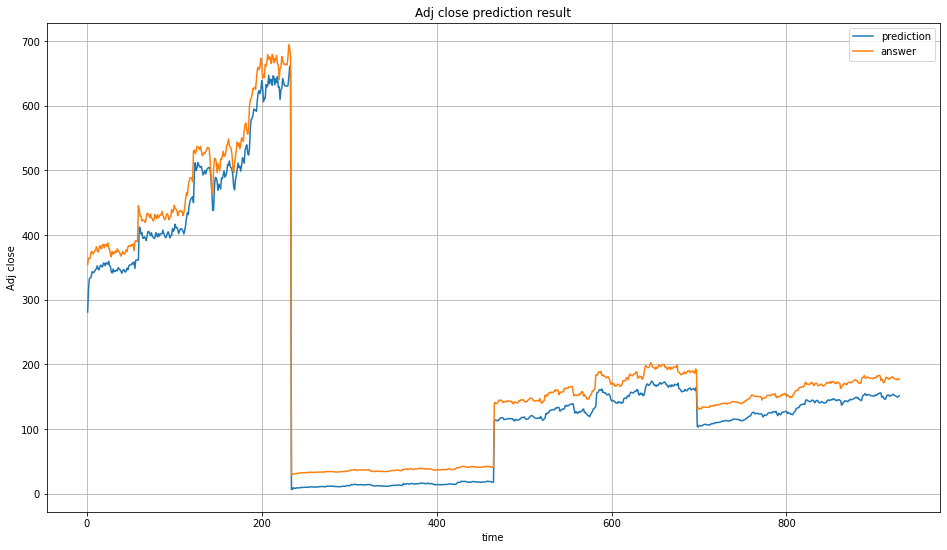

In [223]:
# 증가패턴 수정종가 예측값 그래프 
%matplotlib inline 
x_axis =np.arange(1,pred_scaled.shape[0]+1)
from matplotlib import pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(x_axis,pred_scaled) # line1 plot(x레이블, y레이블)
plt.plot(x_axis,ans_scaled) # line2 plot(x레이블, y레이블)
plt.xlabel('time')
plt.ylabel('Adj close')
plt.title('Adj close prediction result')
plt.legend(['prediction', 'answer']) #plt.legend([라인1범례, 라인2범례])
plt.grid(True) #격자 표시 여부

fig = plt.gcf()
fig.savefig("image/" +PATH+"_increase pattern_loss.png")
plt.show()


In [224]:
#전날 기준 증가 감소여부 예측 정확도 평가
predict_label_inc = check_class(pred_scaled)
accuracy, f1, precision, recall  = model_test_score(DATASET_TEST_INC, TEST_MODEL, test_scaler)

print("=================LSTM모델 예측 결과==================")
print("증가 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가")
print("(1) accuracy score = ",  accuracy)
print("(2) recall score = ",  recall)
print("(3) precision score = ", precision)
print("(4) f1 score = ",  f1 )

=================LSTM모델 예측 결과==================
증가 패턴 수정 종가에 대한 증가 감소 예측 정확도 평가
(1) accuracy score =  0.462
(2) recall score =  0.501
(3) precision score =  0.499
(4) f1 score =  0.5


### 4-2. 감소 패턴 데이터셋 테스트

In [225]:
# 테스트 데이터셋에 대하여, generated data 만들기
# generated data가 test_predict
# test answer는  test_predict기 예측하는 시점에서의 정답값
# test_label는 전날 기준으로 상승(1) 하강(0) 여부를 나타내는 클래스
test_predict_dec, test_answer_dec,  test_label_dec = get_result(DATASET_TEST_DEC , BATCH_SIZE, TEST_MODEL)

#예측값과 정답값에서 수정종가에 대하여 inverse_normalize 적용
pred_scaled_dec = test_scaler.inverse_transform(test_predict_dec.reshape(-1, 1))
ans_scaled_dec = test_scaler.inverse_transform(test_answer_dec[:,3].reshape(-1, 1))

print(pred_scaled_dec.shape)
print(ans_scaled_dec.shape)

(931, 1)
(931, 1)


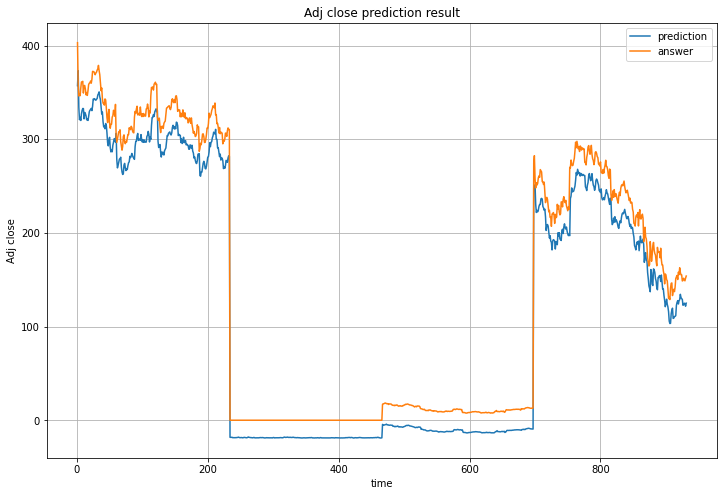

In [226]:
# 감소 패턴 수정종가 예측값 그래프 
%matplotlib inline 
x_axis =np.arange(1,pred_scaled_dec.shape[0]+1)
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(x_axis,pred_scaled_dec) # line1 plot(x레이블, y레이블)
plt.plot(x_axis,ans_scaled_dec) # line2 plot(x레이블, y레이블)
plt.xlabel('time')
plt.ylabel('Adj close')
plt.title('Adj close prediction result')
plt.legend(['prediction', 'answer']) #plt.legend([라인1범례, 라인2범례])
plt.grid(True) #격자 표시 여부
fig = plt.gcf()
fig.savefig("image/"+PATH+ "_decrease pattern_loss.png")
plt.show()


In [227]:
#전날 기준 증가 감소여부 예측 정확도 평가
predict_label_dec = check_class(pred_scaled_dec)
accuracy, f1, precision, recall  = model_test_score(DATASET_TEST_DEC, TEST_MODEL, test_scaler)

print("=================LSTM 모델 예측 결과===================")
print("감소패턴 수정 종가에 대한 증가 감소 예측 정확도 평가")
print("(1) accuracy score = ",  accuracy)
print("(2) recall score = ",  recall)
print("(3) precision score = ", precision)
print("(4) f1 score = ",  f1 )


=================LSTM 모델 예측 결과===================
감소패턴 수정 종가에 대한 증가 감소 예측 정확도 평가
(1) accuracy score =  0.507
(2) recall score =  0.467
(3) precision score =  0.499
(4) f1 score =  0.483
